<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Seyed Mohammad Ojagh Kazzazi

**Student ID**: 400100554





## Importing Libraries

First we import libraries that we need for this assignment.

In [184]:
# import any other libraries needed below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [185]:
# Read the CSV file into a DataFrame
data = pd.read_csv('Q3/data_logistic.csv')

# Extract the feature matrix X and target vector Y
X = data[['X1', 'X2', 'X3']]
Y = data['Y']

print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:

Normalization is an important step in preprocessing because it scales the data to a standard range. This is particularly important when the features have different scales, units or ranges. By normalizing, we ensure that each feature contributes approximately proportionately to the final distance.

Another reason is that many machine learning algorithms (like gradient descent) converge faster when features are on a similar scale.

In [186]:
X_normalized = (X - np.mean(X , axis=0)) / np.std(X , axis=0)


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [187]:
### START CODE HERE ###
X = np.hstack((np.ones((X_normalized.shape[0], 1)), X_normalized))
### END CODE HERE ###

print(X.shape)

(10000, 4)


In [188]:
X

array([[ 1.        , -1.00066149, -0.60536985, -0.85021999],
       [ 1.        , -1.45366949,  1.73051062, -0.20238503],
       [ 1.        ,  0.26239007,  1.69140966,  0.64234794],
       ...,
       [ 1.        ,  1.35418019, -0.1188587 ,  1.41249602],
       [ 1.        ,  1.41727838,  0.76498604,  0.94404812],
       [ 1.        ,  0.79312016,  1.49592029,  0.85670437]])

## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [189]:
def sigmoid(Z):
    '''
    Applies the sigmoid function on every element of Z
    Arguments:
        Z can be a (n,) vector or (n , m) matrix
    Returns:
        A vector/matrix, same shape with Z, that has the sigmoid function applied elementwise
    '''
    return 1 / (1 + np.exp(-Z))


In [190]:
# Test with a scalar
print(sigmoid(0))  # Expected output: 0.5

# Test with a 1D numpy array
print(sigmoid(np.array([-1, 0, 1])))  # Expected output: array([0.26894142, 0.5       , 0.73105858])

# Test with a 2D numpy array
print(sigmoid(np.array([[0, 1], [-1, 2]])))  # Expected output: array([[0.5       , 0.73105858], [0.26894142, 0.88079708]])

0.5
[0.26894142 0.5        0.73105858]
[[0.5        0.73105858]
 [0.26894142 0.88079708]]


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [191]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost
    '''
    
    m, n = X.shape
    h = sigmoid(np.dot(X ,theta))
    term1 = y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    regularization = (regLambda / 2) * np.sum(np.square(theta))
    loss = -np.sum(term1 + term2) / m + regularization
    return loss



### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:

The gradient of the cost function for the $j^{th}$ element (for $j=1...d$) is given by:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j
$$

This formula is similar to the one for the $0^{th}$ element, but with an additional term $\frac{\lambda}{m}\theta_j$ for regularization. This term helps to prevent overfitting by penalizing large values of $\theta_j$. Note that this regularization term is not applied to $\theta_0$.

In [192]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        the gradient, an d-dimensional vector
    '''
    
    m, n = X.shape
    h = sigmoid(np.dot(X, theta))
    
    # Compute the gradient
    grad = (1 / m) * np.dot(X.T, (h - y)) + (regLambda / m) * theta
    
    # Do not regularize the first element (theta_0)
    grad[0] = (1 / m) * np.dot(X[:, 0], (h - y))
    
    return grad

### Training and Prediction
Once you have the cost and gradient functions complete, implement the fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [193]:
def fit(X, y, regLambda = 0.01, alpha = 0.01, epsilon = 1e-4, maxNumIters = 100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''
    
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []

    for _ in range(maxNumIters):
        gradient = computeGradient(theta, X, y, regLambda)
        new_theta = theta - alpha * gradient

        if hasConverged(theta, new_theta, epsilon):
            break

        theta = new_theta
        loss_history.append(computeCost(theta, X, y, regLambda))

    return theta, np.array(loss_history)


def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in prevoius iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''
    
    return np.sqrt(np.sum((theta_new - theta_old)**2)) <= epsilon

Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [194]:
# Assuming X and Y are your data and labels respectively

theta, loss_history = fit(X, Y)

# Print the final model parameters
print("Final model parameters (theta):")
print(theta)

# Print the loss at each iteration
print("\nLoss at each iteration:")
for i, loss in enumerate(loss_history):
    print(f"Iteration {i}: {loss}")

Final model parameters (theta):
[ 0.14721272 -0.21750811  0.23679233  0.07455652]

Loss at each iteration:
Iteration 0: 0.691486988340543
Iteration 1: 0.6898353250903184
Iteration 2: 0.6881921471981215
Iteration 3: 0.6865574110987143
Iteration 4: 0.6849310732766268
Iteration 5: 0.68331309026995
Iteration 6: 0.6817034186740645
Iteration 7: 0.680102015145306
Iteration 8: 0.6785088364045683
Iteration 9: 0.6769238392408417
Iteration 10: 0.6753469805146889
Iteration 11: 0.6737782171616564
Iteration 12: 0.6722175061956249
Iteration 13: 0.6706648047120923
Iteration 14: 0.6691200698913975
Iteration 15: 0.6675832590018788
Iteration 16: 0.6660543294029714
Iteration 17: 0.6645332385482391
Iteration 18: 0.6630199439883467
Iteration 19: 0.6615144033739688
Iteration 20: 0.6600165744586352
Iteration 21: 0.658526415101517
Iteration 22: 0.6570438832701506
Iteration 23: 0.6555689370430983
Iteration 24: 0.6541015346125519
Iteration 25: 0.6526416342868725
Iteration 26: 0.6511891944930719
Iteration 27: 0.6

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [195]:
# Assuming data is your DataFrame and labels are your target values
data, labels = X, Y

# Split the data into training and temporary sets
X_train, X_temp, Y_train, Y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)

# Further split the temporary set into test and validation sets
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 7000
Validation set size: 2000
Test set size: 1000


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [196]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta is d-dimensional numpy vector
        X     is a n-by-d numpy matrix
    Returns:
        an n-dimensional numpy vector of the predictions, the output should be binary (use h_theta > .5)
    '''
    
    # Compute the hypothesis
    h = sigmoid(np.dot(X, theta))
    
    # Convert the hypothesis to binary predictions
    Y = (h > 0.5).astype(int)
    
    return Y

Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

<div style="color:pink;">

**Answer**:


1. **Learning Rate**: The learning rate controls how much the model parameters are updated at each step of the gradient descent algorithm. A high learning rate can cause the model to converge quickly, but it may also overshoot the optimal solution and diverge. A low learning rate can ensure that the model does not miss the optimal solution, but it may cause the model to converge slowly. Therefore, it's important to choose a learning rate that's neither too high nor too low. In the plot, different learning rates will affect the speed at which the loss decreases.

2. **Regularization Constant**: The regularization constant controls the amount of regularization in the model. Regularization is a technique used to prevent overfitting by adding a penalty to the loss function. A high regularization constant increases the penalty and thus reduces the complexity of the model, which can help to prevent overfitting but may also lead to underfitting. A low regularization constant reduces the penalty and thus allows the model to have higher complexity, which can fit the training data better but may also lead to overfitting. In the plot, different regularization constants will affect the final value of the loss.

To find the best values of these parameters, you can use techniques like grid search or random search, where you try different combinations of the parameters and choose the one that gives the best performance on the validation set. In the plot, the combination of learning rate and regularization constant that results in the lowest loss on the test set would be the best values of these parameters.

</div>

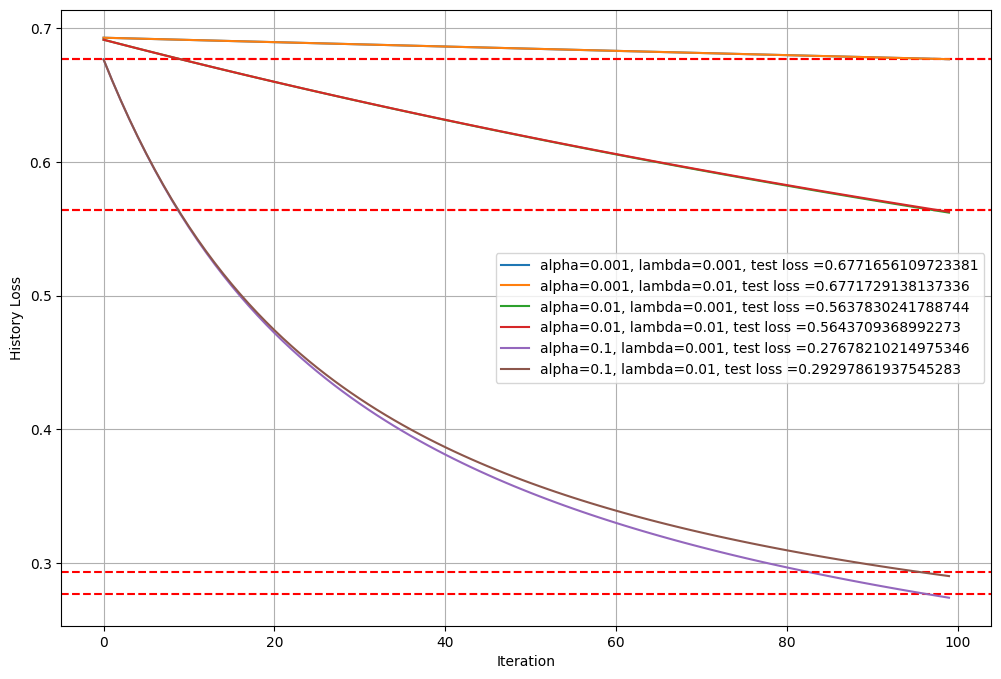

In [197]:
# Define the learning rates and regularization constants to try
learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.001, 0.01]


# Initialize a figure
plt.figure(figsize=(12, 8))

# Initialize a list to store the final loss of each loss history
final_losses = []

# Loop over the learning rates and regularization constants
for alpha in learning_rates:
    for regLambda in reg_constants:
        # Train the model and get the loss history
        theta, loss_history = fit(X_train, Y_train, regLambda, alpha)
        
        # Store the final loss in final_losses
        if loss_history.size:  # Check if loss_history is not empty
            final_losses.append(loss_history[-1])
        
        # Predict the labels for the test set
        y_pred = predict(X_val, theta)
        
        # Compute the loss for the test set
        test_loss = computeCost(theta, X_test, Y_test, regLambda)
        

        plt.axhline(test_loss, color='red', linestyle='--')

        # Plot the loss history
        plt.plot(loss_history, label=f'alpha={alpha}, lambda={regLambda}, test loss ={test_loss}')

# Compute the global minimum and maximum final loss
if final_losses:  # Check if final_losses is not empty
    global_min_loss = min(final_losses)
    global_max_loss = max(final_losses)

# Add labels and a legend
plt.xlabel('Iteration')
plt.ylabel('History Loss')
plt.legend()
plt.grid(True)
plt.show()

## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [198]:
# Create a GaussianNB object
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, Y_train)

# Predict the labels for the test data
Y_pred = gnb.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)

print(f'The accuracy of the GaussianNB classifier on the test set is: {accuracy}')

The accuracy of the GaussianNB classifier on the test set is: 0.929


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [199]:
# Create a LinearDiscriminantAnalysis object
lda = LinearDiscriminantAnalysis()

# Fit the model to the training data
lda.fit(X_train, Y_train)

# Predict the labels for the test data
Y_pred = lda.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)

print(f'The accuracy of the LDA classifier on the test set is: {accuracy}')

The accuracy of the LDA classifier on the test set is: 0.985


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: Best method is LDA, with accuracy = 0.985